In [1538]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates  
import json
import os
from datetime import datetime
# import plotly.graph_objects as go
# from Custom_tools.plotting_utils import plot_ohlc_with_sr

In [1539]:
filename = input("Enter filename in capital letters: ") 
timeframe = 5

#### Data Wrangling

In [1540]:
# ["ADANIPORTS","AXISBANK","HDFCBANK", "HINDALCO","ICICIBANK", "INFY", "M&M", "RELIANCE", "POWERGRID", "SBIN"]

In [1541]:
# df = pd.read_csv(f"../Data/1_minute_data/{filename}").set_index("datetime")
# df.index = pd.to_datetime(df.index)

In [1542]:
df = pd.read_parquet(
    f"s3://quant-ohlcv-data/ohlcv/timeframe={timeframe}min/symbol={filename}/"
)
if "datetime" in df.columns:
    df = df.set_index("datetime")

In [1543]:
# start_date = pd.Timestamp("2023-02-01", tz="Asia/Kolkata")
# end_date   = pd.Timestamp("2025-12-31", tz="Asia/Kolkata")

# df = df.loc[start_date:end_date]

In [1544]:
df.head()

,open,high,low,close,volume
datetime,,,,,
2018-01-01 09:20:00+05:30,457.02,457.02,456.08,456.47,134966
2018-01-01 09:25:00+05:30,456.47,456.55,455.95,456.18,143684
2018-01-01 09:30:00+05:30,456.18,456.20,455.73,456.20,54946
2018-01-01 09:35:00+05:30,456.20,456.30,455.80,455.83,56054
2018-01-01 09:40:00+05:30,455.80,455.83,454.19,454.52,170398


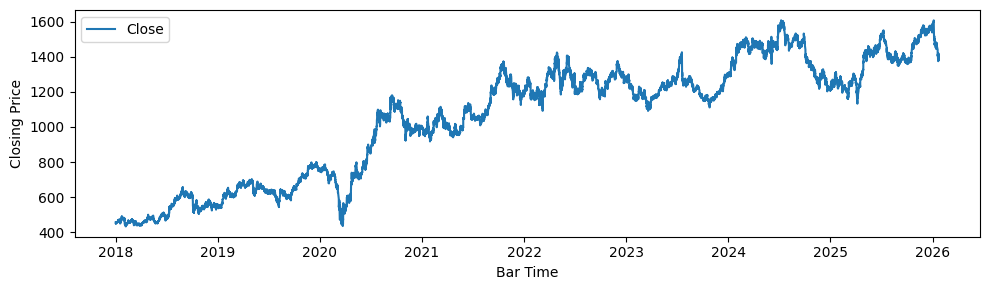

In [1545]:
fig, ax = plt.subplots(figsize=(10, 3))

ax.plot(df["close"], label="Close")

ax.set_xlabel("Bar Time")
ax.set_ylabel("Closing Price")

plt.legend()
plt.tight_layout()
plt.show()


In [1546]:
df["resistance"] = df["close"].shift().rolling(10).max()
df["support"]    = df["close"].shift().rolling(10).min()

df= df.dropna(how="any")


In [1547]:
df[["close","support","resistance"]].head()

,close,support,resistance
datetime,,,
2018-01-01 10:10:00+05:30,455.41,454.52,456.47
2018-01-01 10:15:00+05:30,455.43,454.52,456.20
2018-01-01 10:20:00+05:30,455.61,454.52,456.20
2018-01-01 10:25:00+05:30,455.66,454.52,455.83
2018-01-01 10:30:00+05:30,455.36,454.52,455.66


In [1548]:
# plot_ohlc_with_sr(df.tail(75))

In [1549]:
df[["close", "high", "low", "support", "resistance"]].head()

,close,high,low,support,resistance
datetime,,,,,
2018-01-01 10:10:00+05:30,455.41,455.58,454.99,454.52,456.47
2018-01-01 10:15:00+05:30,455.43,455.58,455.21,454.52,456.20
2018-01-01 10:20:00+05:30,455.61,455.61,454.94,454.52,456.20
2018-01-01 10:25:00+05:30,455.66,455.68,455.43,454.52,455.83
2018-01-01 10:30:00+05:30,455.36,455.68,455.19,454.52,455.66


    ATR implementation for stop loss

In [1550]:
# Calculate True Range (Wilder's definition)
df['prev_close'] = df['close'].shift(1)
df['tr'] = df[['high', 'low', 'prev_close']].apply(
    lambda x: max(x['high'] - x['low'], 
                      abs(x['high'] - x['prev_close']), 
                                        abs(x['low'] - x['prev_close'])), axis=1
                                        )
df['atr'] = df['tr'].shift().rolling(14).mean()

#### Indicators as filter

In [1551]:
# Calculate RSI (14-period standard)
def calculate_rsi(data, period=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Add RSI
df['rsi'] = calculate_rsi(df['close'], period=14).shift()  # shift to avoid lookahead


#### Creating Strategy

    Adding a trend filter.

In [1552]:
# Add simple trend filter
df['sma_50'] = df['close'].shift().rolling(50).mean()
df['sma_200'] = df['close'].shift().rolling(200).mean()
df["sma_20"] = df["close"].shift().rolling(20).mean() 

# Uptrend: price > SMA50 > SMA200
df['uptrend'] = (
                 (df["open"]>df["sma_20"])
                 ).astype(int)

df["downtrend"] = (
                 (df["open"]<df["sma_20"])
                 ).astype(int)


    Fakeout Indicator

In [1553]:
df["prev_close"] = df["close"].shift(1)
df["prev_low"] = df["low"].shift(1)
df["prev_support"] = df["support"].shift(1)
df["prev_resistance"] = df["resistance"].shift()
# df[["close","prev_close","low", "prev_low"]].head(3)

    Calculating Entry Signal 

In [1554]:
df['entry_signal'] = (
    # (df['low'] <= df['support'])
     (df["prev_close"]<df["prev_support"]) & (df["high"]>=df["support"])
).astype(int)


df['entry_signal_short'] = (
    # (df['high'] >= df['resistance'])
    (df["prev_close"]>df["prev_resistance"]) & (df["low"]>=df["support"])
    
).astype(int)

    Calculating Entry Price

In [1555]:
df["entry_price"] = np.where(df["entry_signal"]==1, df["support"], np.nan)

    Calculating Exit conditions

In [1556]:
df["target_price"] = np.where(df["entry_signal"]==1, df["resistance"], np.nan )

df["stop_loss_price"] = np.where(df["entry_signal"]==1, df["entry_price"]-(1 * df["atr"]), np.nan)

#### Creating positions

    Initializing variables

#### Creating Long Positions

In [1557]:
#INitializing trade pnl logic
df["trade_pnl"] = 0.0
df["exit_reason"] = ''
df["in_position"] = 0
trade_pnls = []
starting_capital = df.iloc[0]['close']
# starting_capital = 10000


entry_price = np.nan
stop_price = np.nan
target_price = np.nan
in_trade = False
TRANSACTION_COST = 0.0002

#For machine Learning
entry_index = None
df["ml_target"] =  np.nan
df["holding_period"] = np.nan

In [1558]:
for i in range(len(df)):
    idx = df.index[i]

    #Mark if we are in position in this bar

    df.loc[idx, "in_position"] = 1 if  in_trade else 0


    #Exit logic first

    if in_trade:
        current_low = df.loc[idx, "low"]
        current_high = df.loc[idx, "high"]

        #Exit conditions
        if current_low<= stop_price:
            exit_price = stop_price
            exit_reason = "STOP" 
        elif current_high >= target_price:
            exit_price = target_price
            exit_reason = "TARGET"
        else:
            exit_price = None
        #Calculating PNL
        if exit_price is not None:
            pnl_per_share_gross = exit_price - entry_price
            
            #Calculating transaction cost
            cost_entry_per_share = entry_price * TRANSACTION_COST
            cost_exit_per_share = exit_price * TRANSACTION_COST
            total_cost_per_share = cost_entry_per_share + cost_exit_per_share

            pnl_per_share_net = pnl_per_share_gross - total_cost_per_share

            #Calculate position size
            # position_value = starting_capital
            # shares = position_value/entry_price
            shares = 1

            #Total pnl for the position
            pnl_total_gross = pnl_per_share_gross * shares
            total_cost_total = total_cost_per_share * shares
            pnl_total_net = pnl_per_share_net * shares

            trade_pnls.append(pnl_total_net)

            # Assign to dataframe at exit bar

            df.loc[idx, 'trade_pnl'] =  pnl_total_net
            df.loc[idx, 'exit_reason'] = exit_reason
            # Use percentage return (comparable across stocks):
            df.loc[entry_index, 'ml_target'] = (pnl_per_share_net / entry_price) * 100
            df.loc[entry_index, "holding_period"] = i - df.index.get_loc(entry_index)


            #Reset state

            in_trade = False
            entry_price = np.nan
            stop_price = np.nan
            target_price = np.nan
    
    #Entry logic
    elif df.loc[idx, "entry_signal"] == 1:
        in_trade = True
        entry_price = df.loc[idx, "entry_price"]
        stop_price = df.loc[idx, "stop_loss_price"]
        target_price = df.loc[idx, "target_price"]

        entry_index = idx

 

In [1559]:
np.sum(trade_pnls)

np.float64(-3404.6310242857658)

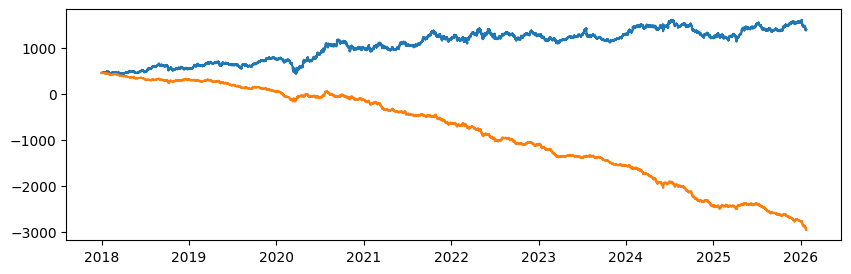

In [1560]:
df["cumulative_pnl"] = df["trade_pnl"].cumsum()
df["equity_curve"] = starting_capital + df["cumulative_pnl"]

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(df["close"])
ax.plot(df["equity_curve"])

In [1561]:
# Add this right after your loop
print(f"\nTotal trades executed: {len(trade_pnls)}")
print(f"ML targets stored: {df['ml_target'].notna().sum()}")
print(f"Entry signals: {(df['entry_signal'] == 1).sum()}")


Total trades executed: 9464
ML targets stored: 9464
Entry signals: 22848


#### Adding shorting opportunities

In [1562]:
# Entry at close when price touches resistance
df["entry_price_short"] = np.where(df["entry_signal_short"]==1, 
                                    df["resistance"], 
                                    np.nan)

In [1563]:

df["target_price_short"] = np.where(df["entry_signal_short"]==1, 
                                    df["support"],  # or df["close"] - (2 * df["atr"])
                                    np.nan)

# Stop ABOVE entry (correct - you have this right!)
df["stop_loss_price_short"] = np.where(df["entry_signal_short"]==1, 
                                       df["entry_price_short"] + (1 * df["atr"]), 
                                       np.nan)

In [1564]:
# Initializing trade pnl logic for SHORTS
df["trade_pnl_short"] = 0.0
df["exit_reason_short"] = ''
df["in_position_short"] = 0
trade_pnls_short = []
starting_capital_short = df.iloc[0]['close']
# starting_capital_short = 10000

entry_price_short = np.nan
stop_price_short = np.nan
target_price_short = np.nan
in_trade_short = False
TRANSACTION_COST_SHORT = 0.0002  # Consider if shorts have higher costs

# For machine learning
entry_index_short = None
df["ml_target_short"] = np.nan
df["holding_period_short"] = np.nan

In [1565]:
for i in range(len(df)):
    idx = df.index[i]

    # Mark if we are in position in this bar
    df.loc[idx, "in_position_short"] = 1 if in_trade_short else 0

    # Exit logic first
    if in_trade_short:
        current_low = df.loc[idx, "low"]
        current_high = df.loc[idx, "high"]

        # Exit conditions (INVERTED for shorts)
        if current_high >= stop_price_short:  # Stop hit when price goes UP
            exit_price = stop_price_short
            exit_reason = "STOP" 
        elif current_low <= target_price_short:  # Target hit when price goes DOWN
            exit_price = target_price_short
            exit_reason = "TARGET"
        else:
            exit_price = None
            
        # Calculating PNL
        if exit_price is not None:
            # INVERTED: profit when exit < entry for shorts
            pnl_per_share_gross = entry_price_short - exit_price  
            
            # Calculating transaction cost
            cost_entry_per_share = entry_price_short * TRANSACTION_COST_SHORT
            cost_exit_per_share = exit_price * TRANSACTION_COST_SHORT
            total_cost_per_share = cost_entry_per_share + cost_exit_per_share

            pnl_per_share_net = pnl_per_share_gross - total_cost_per_share

            # Calculate position size
            # position_value = starting_capital_short
            # shares = position_value / entry_price_short
            shares = 1

            # Total pnl for the position
            pnl_total_gross = pnl_per_share_gross * shares
            total_cost_total = total_cost_per_share * shares
            pnl_total_net = pnl_per_share_net * shares

            trade_pnls_short.append(pnl_total_net)

            # Assign to dataframe at exit bar
            df.loc[idx, 'trade_pnl_short'] = pnl_total_net
            df.loc[idx, 'exit_reason_short'] = exit_reason
            
            # Use percentage return (comparable across stocks):
            df.loc[entry_index_short, 'ml_target_short'] = (pnl_per_share_net / entry_price_short) * 100
            df.loc[entry_index_short, "holding_period_short"] = i - df.index.get_loc(entry_index_short)

            # Reset state
            in_trade_short = False
            entry_price_short = np.nan
            stop_price_short = np.nan
            target_price_short = np.nan
    
    # Entry logic
    elif (df.loc[idx, "entry_signal_short"] == 1) and (not in_trade_short):

        in_trade_short = True
        entry_price_short = df.loc[idx, "entry_price_short"]
        stop_price_short = df.loc[idx, "stop_loss_price_short"]
        target_price_short = df.loc[idx, "target_price_short"]
        
        entry_index_short = idx

In [1566]:
np.sum(trade_pnls_short)

np.float64(-3292.246584857177)

In [1567]:
df["trade_pnl_total"] = df["trade_pnl"] + df["trade_pnl_short"]


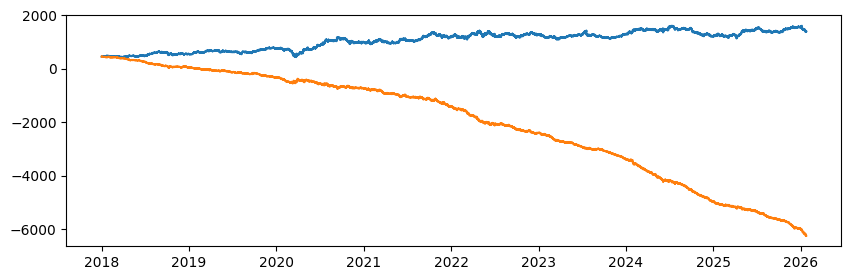

In [1568]:
df["cumulative_pnl"] = df["trade_pnl_total"].cumsum()
df["equity_curve"] = starting_capital + df["cumulative_pnl"]

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(df["close"])
ax.plot(df["equity_curve"])

#### Year On Year Results

C:\Users\LuvRatan\AppData\Local\Temp\ipykernel_37156\3620161310.py:43: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_df = df.groupby('year').apply(calculate_year_metrics).reset_index()
C:\Users\LuvRatan\AppData\Local\Temp\ipykernel_37156\3620161310.py:49: RuntimeWarning: invalid value encountered in scalar power
  cagr = ((last_equity / first_equity) ** (1 / years_total) - 1) * 100


YEAR-ON-YEAR PERFORMANCE
 year  Start Equity   End Equity  Total Return (%)  Max Drawdown (%)  Trades  Win Rate (%)  Avg Win  Avg Loss  Sharpe Ratio
 2018    455.410000    52.266198        -88.523265        -91.394693  2136.0     31.320225 2.493406 -1.411883     -0.141445
 2019     51.197308  -318.828614       -722.744882       -659.867280  2055.0     31.240876 3.197992 -1.715644     -0.127573
 2020   -318.828614  -736.306681        130.941217         -0.000000  2074.0     29.990357 6.149572 -2.921840      0.241460
 2021   -731.504181 -1400.350845         91.434428         -0.000000  2092.0     31.548757 5.462967 -2.981566      0.364870
 2022  -1402.617530 -2403.847947         71.382996         -0.000000  2154.0     29.387187 6.323525 -3.291445      0.493697
 2023  -2403.847947 -3384.329053         40.787984         -0.000000  2036.0     31.237721 3.927632 -2.484611      0.701917
 2024  -3384.329053 -4966.258097         46.742767         -0.000000  2255.0     29.534368 5.499710 -3.3006

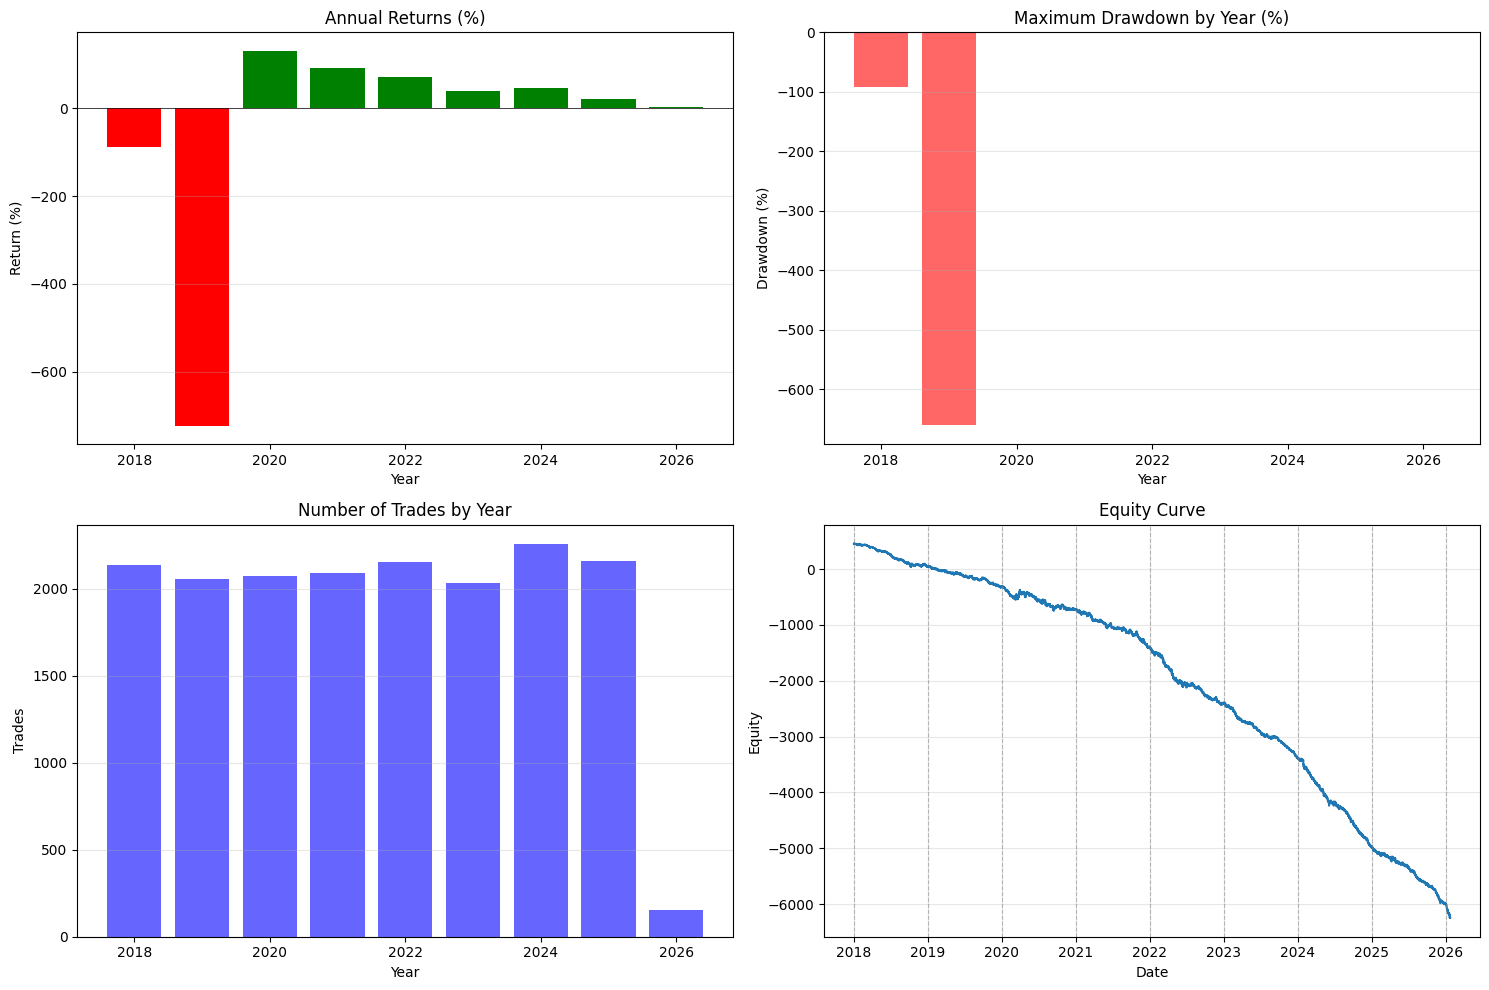

,year,Start Equity,End Equity,Total Return (%),Max Drawdown (%),Trades,Win Rate (%),Avg Win,Avg Loss,Sharpe Ratio
0,2018,455.410000,52.266198,-88.523265,-91.394693,2136.0,31.320225,2.493406,-1.411883,-0.141445
1,2019,51.197308,-318.828614,-722.744882,-659.867280,2055.0,31.240876,3.197992,-1.715644,-0.127573
2,2020,-318.828614,-736.306681,130.941217,-0.000000,2074.0,29.990357,6.149572,-2.921840,0.241460
3,2021,-731.504181,-1400.350845,91.434428,-0.000000,2092.0,31.548757,5.462967,-2.981566,0.364870
4,2022,-1402.617530,-2403.847947,71.382996,-0.000000,2154.0,29.387187,6.323525,-3.291445,0.493697
5,2023,-2403.847947,-3384.329053,40.787984,-0.000000,2036.0,31.237721,3.927632,-2.484611,0.701917
6,2024,-3384.329053,-4966.258097,46.742767,-0.000000,2255.0,29.534368,5.499710,-3.300652,0.816358
7,2025,-4966.258097,-6007.153576,20.959351,-0.000000,2159.0,31.959240,4.753815,-2.941476,0.565882
8,2026,-6001.082756,-6241.467609,4.005691,-0.000000,152.0,23.026316,5.066553,-3.518319,2.155815


In [1569]:
df['year'] = df.index.year

# Group by year and calculate metrics
def calculate_year_metrics(group):
    # Equity metrics
    start_equity = group['equity_curve'].iloc[0]
    end_equity = group['equity_curve'].iloc[-1]
    year_return = (end_equity - start_equity) / start_equity * 100
    
    # Drawdown
    running_max = group['equity_curve'].cummax()
    drawdown = (group['equity_curve'] - running_max) / running_max * 100
    max_drawdown = drawdown.min()
    
    # Trade metrics
    trades = group[group['trade_pnl_total'] != 0]
    num_trades = len(trades)
    winning_trades = len(trades[trades['trade_pnl_total'] > 0])
    losing_trades = len(trades[trades['trade_pnl_total'] < 0])
    win_rate = (winning_trades / num_trades * 100) if num_trades > 0 else 0
    
    # Average win/loss
    avg_win = trades[trades['trade_pnl_total'] > 0]['trade_pnl_total'].mean() if winning_trades > 0 else 0
    avg_loss = trades[trades['trade_pnl_total'] < 0]['trade_pnl_total'].mean() if losing_trades > 0 else 0
    
    # Sharpe ratio
    daily_returns = group['equity_curve'].pct_change().dropna()
    sharpe = np.sqrt(252) * daily_returns.mean() / daily_returns.std() if len(daily_returns) > 1 and daily_returns.std() > 0 else 0
    
    return pd.Series({
        'Start Equity': start_equity,
        'End Equity': end_equity,
        'Total Return (%)': year_return,
        'Max Drawdown (%)': max_drawdown,
        'Trades': num_trades,
        'Win Rate (%)': win_rate,
        'Avg Win': avg_win,
        'Avg Loss': avg_loss,
        'Sharpe Ratio': sharpe
    })

# Apply to all years at once
yearly_df = df.groupby('year').apply(calculate_year_metrics).reset_index()

# Calculate overall CAGR
first_equity = df['equity_curve'].iloc[0]
last_equity = df['equity_curve'].iloc[-1]
years_total = (df.index[-1] - df.index[0]).days / 365.25
cagr = ((last_equity / first_equity) ** (1 / years_total) - 1) * 100

# Overall max drawdown
running_max_all = df['equity_curve'].cummax()
drawdown_all = (df['equity_curve'] - running_max_all) / running_max_all * 100
max_dd_all = drawdown_all.min()

print("=" * 80)
print("YEAR-ON-YEAR PERFORMANCE")
print("=" * 80)
print(yearly_df.to_string(index=False))
print("\n" + "=" * 80)
print("OVERALL METRICS")
print("=" * 80)
print(f"Starting Capital: ₹{first_equity:,.2f}")
print(f"Ending Capital: ₹{last_equity:,.2f}")
print(f"Total Return: {((last_equity/first_equity - 1) * 100):.2f}%")
print(f"CAGR: {cagr:.2f}%")
print(f"Max Drawdown: {max_dd_all:.2f}%")
print(f"Total Period: {years_total:.2f} years")
print("=" * 80)

# Same visualizations as before
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].bar(yearly_df['year'], yearly_df['Total Return (%)'], 
               color=['green' if x > 0 else 'red' for x in yearly_df['Total Return (%)']])
axes[0, 0].set_title('Annual Returns (%)')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Return (%)')
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)

axes[0, 1].bar(yearly_df['year'], yearly_df['Max Drawdown (%)'], color='red', alpha=0.6)
axes[0, 1].set_title('Maximum Drawdown by Year (%)')
axes[0, 1].set_xlabel('Year')
axes[0, 1].set_ylabel('Drawdown (%)')
axes[0, 1].grid(axis='y', alpha=0.3)

axes[1, 0].bar(yearly_df['year'], yearly_df['Trades'], color='blue', alpha=0.6)
axes[1, 0].set_title('Number of Trades by Year')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Trades')
axes[1, 0].grid(axis='y', alpha=0.3)

axes[1, 1].plot(df.index, df['equity_curve'], linewidth=1.5)
axes[1, 1].set_title('Equity Curve')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Equity')
axes[1, 1].grid(alpha=0.3)

for year in yearly_df['year'].unique():
    year_start = df[df['year'] == year].index[0]
    axes[1, 1].axvline(x=year_start, color='gray', linestyle='--', alpha=0.5, linewidth=0.8)

plt.tight_layout()
plt.show()

yearly_df

In [1570]:
# # Then in the save section:
# results = {
#     'metadata': {
#         'filename': filename,
#         'timeframe': timeframe,
#         'timestamp': datetime.now().isoformat(),
#         'total_period_years': years_total,
#         'starting_capital': first_equity,
#         'ending_capital': last_equity,
#         'total_return_pct': ((last_equity/first_equity - 1) * 100),
#         'cagr_pct': cagr,
#         'max_drawdown_pct': max_dd_all
#     },
#     'yearly_performance': yearly_df.to_dict(orient='records')
# }

# key = f"{filename}_{timeframe}"

# json_filepath = '../research_consolidation/results_json/results_json.json'

# if os.path.exists(json_filepath):
#     with open(json_filepath, 'r') as f:
#         all_results = json.load(f)
# else:
#     all_results = {}

# all_results[key] = results

# with open(json_filepath, 'w') as f:
#     json.dump(all_results, f, indent=2)

# print(f"✓ Results saved with key: {key}")
# print(f"✓ Total runs in file: {len(all_results)}")

#### Sanity Check

In [1571]:
required_columns = ['open', 'high', 'low', 'close', 'volume', 'resistance', 'support','atr', 'rsi', 'sma_50', 'sma_200', 'sma_20','uptrend','ml_target', 'ml_target_short']
df = df[required_columns]
df.head()

,open,high,low,close,volume,resistance,support,atr,rsi,sma_50,sma_200,sma_20,uptrend,ml_target,ml_target_short
datetime,,,,,,,,,,,,,,,
2018-01-01 10:10:00+05:30,455.56,455.58,454.99,455.41,57604,456.47,454.52,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
2018-01-01 10:15:00+05:30,455.41,455.58,455.21,455.43,19862,456.20,454.52,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
2018-01-01 10:20:00+05:30,455.43,455.61,454.94,455.61,32768,456.20,454.52,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
2018-01-01 10:25:00+05:30,455.61,455.68,455.43,455.66,20440,455.83,454.52,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
2018-01-01 10:30:00+05:30,455.66,455.68,455.19,455.36,17808,455.66,454.52,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN


In [1572]:
# required_columns = ['open', 'high', 'low', 'close', 'volume', 'resistance', 'support','atr', 'rsi', 'sma_50', 'sma_200', 'sma_20','uptrend','downtrend']
# df = df[required_columns]
# df.head()

In [1573]:
# df.to_csv(f"./raw_data_for_machine_learning/{filename}_{timeframe}.csv", index='datetime')

In [1574]:
df["ml_target"].notna().sum()

np.int64(9464)

In [1575]:
df["ml_target"].value_counts()

ml_target
 0.253196    2
-0.128239    1
-0.131946    1
-0.111348    1
-0.119931    1
            ..
-0.210386    1
-0.219597    1
-0.229092    1
-0.236619    1
-0.211666    1
Name: count, Length: 9463, dtype: int64

In [1576]:
df["ml_target_short"].notna().sum()

np.int64(8692)

In [1577]:
df["ml_target_short"].value_counts()

ml_target_short
 0.317932    2
 0.311374    2
 0.194839    1
-0.177302    1
 0.446541    1
            ..
-0.186630    1
-0.207100    1
-0.213881    1
 0.385798    1
-0.190588    1
Name: count, Length: 8690, dtype: int64

In [1578]:
df[df["ml_target_short"] == 1]["ml_target_short"]

Series([], Name: ml_target_short, dtype: float64)